## 📦 **Import Libraries**

In [3]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import warnings
warnings.filterwarnings('ignore')

# mount drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import re, string

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from wordcloud import WordCloud

# from googletrans import Translator
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

Mounted at /content/drive


## 🗃️ **Data Preparation**

In [5]:
dir = '/content/drive/MyDrive/Colab Notebooks/ml-stuff/data/'

projects = pd.read_csv(dir + 'projects_stemming_only.csv')

kamus_alay = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv')
# kamus_alay = pd.read_csv(dir + 'colloquial-indonesian-lexicon.csv')
kamus_alay = kamus_alay.filter(['slang', 'formal'], axis = 1).drop_duplicates(subset = ['slang'])
kamus_alay_map = dict(zip(kamus_alay['slang'], kamus_alay['formal']))

#### 📂 **Dataset Information**

In [6]:
projects.head()

,Unnamed: 0,text_clean,finishDays,tags_token,budget
0,0,tulis yang tinggal di apartemen jakarta tulis ...,7.0,['Writing'],250000.0
1,1,buat artikel di media online kerja buat artike...,7.0,"['Blog', 'Blogspot', 'Content Management Syste...",350000.0
2,2,editing 12 shortt video untuk konten tiktok hi...,7.0,"['Social Media Marketing (SMM)', 'Adobe Illust...",200000.0
3,3,cari akun canva creator element atau template ...,7.0,"['Design Arts', 'Graphic Design', 'Logo Design...",1000000.0
4,4,cari jasa upload aplikasi ke app store sedang ...,7.0,['iPhone/iOS'],150000.0


## 📊 **Exploratory Data Analysis**

### **Missing Values Overview**

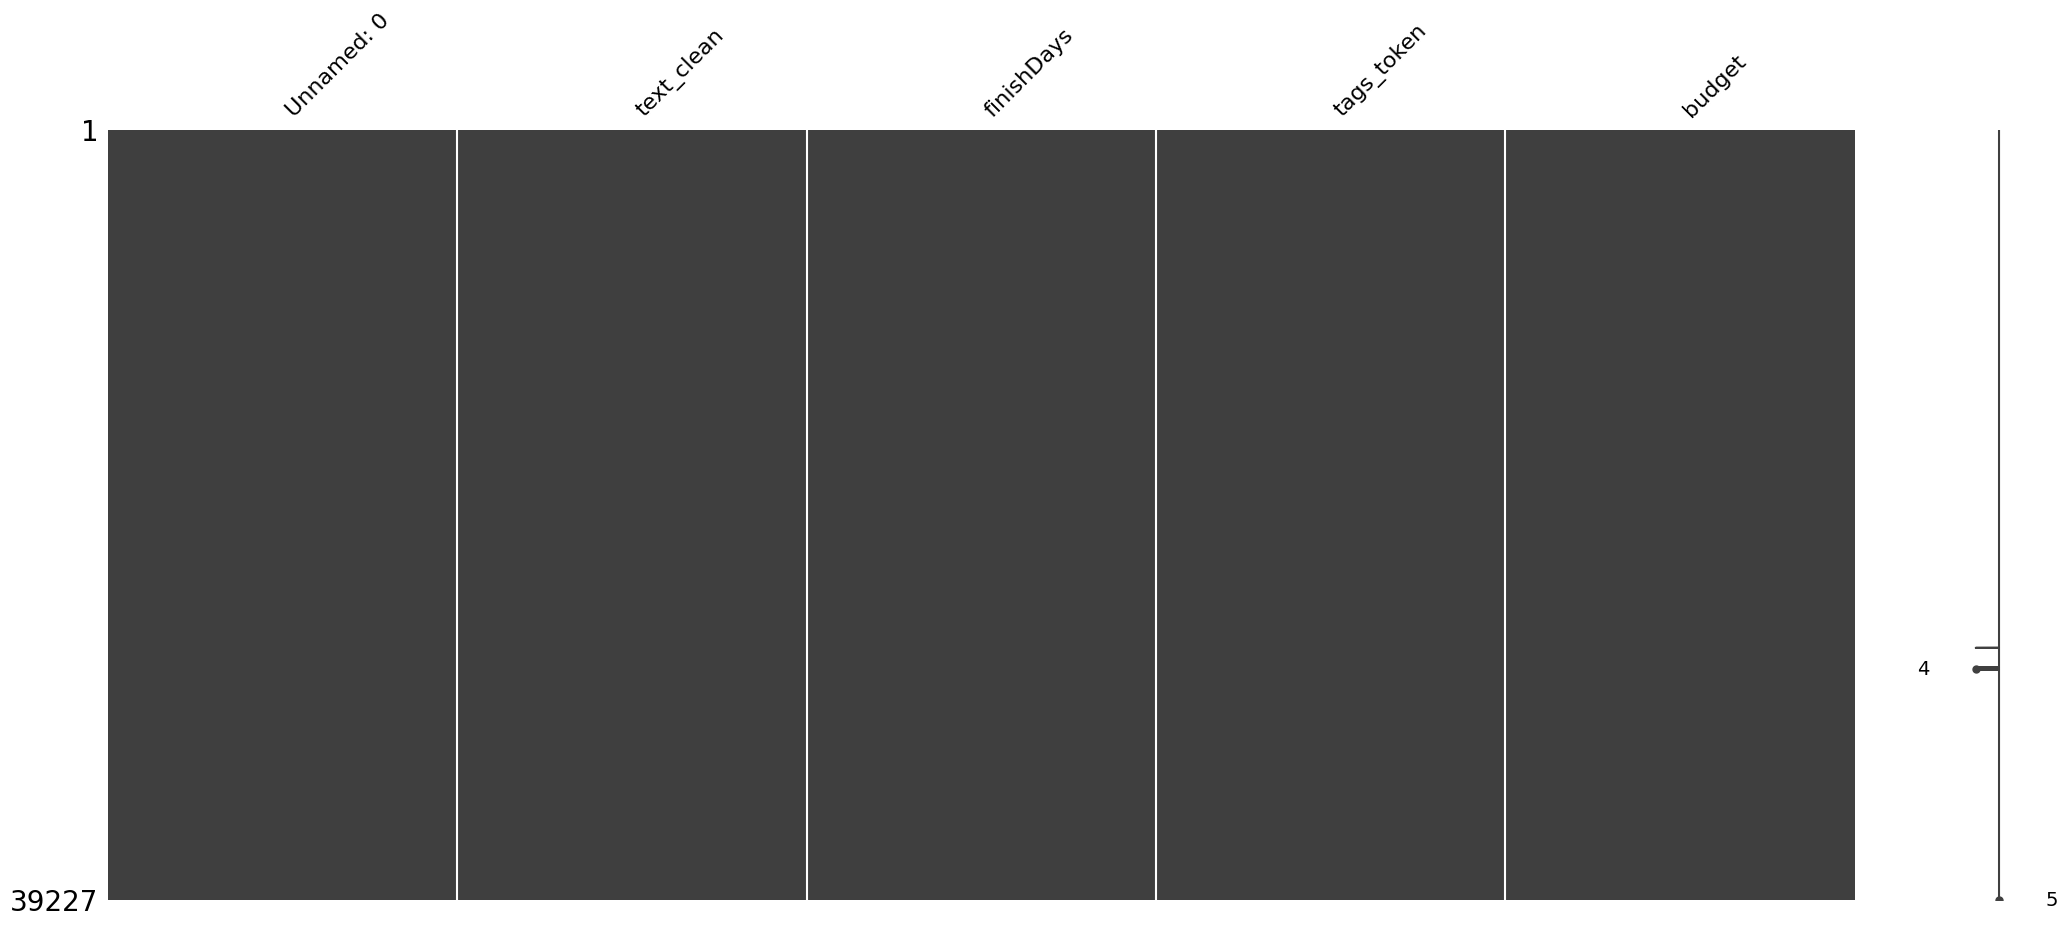

In [7]:
msno.matrix(projects)
plt.show()

In [8]:
round(projects.isna().mean().sort_values(ascending = False), 4)

text_clean    0.0001
Unnamed: 0    0.0000
finishDays    0.0000
tags_token    0.0000
budget        0.0000
dtype: float64

In [9]:
df = projects

In [10]:
df

,Unnamed: 0,text_clean,finishDays,tags_token,budget
0,0,tulis yang tinggal di apartemen jakarta tulis ...,7.0,['Writing'],250000.0
1,1,buat artikel di media online kerja buat artike...,7.0,"['Blog', 'Blogspot', 'Content Management Syste...",350000.0
2,2,editing 12 shortt video untuk konten tiktok hi...,7.0,"['Social Media Marketing (SMM)', 'Adobe Illust...",200000.0
3,3,cari akun canva creator element atau template ...,7.0,"['Design Arts', 'Graphic Design', 'Logo Design...",1000000.0
4,4,cari jasa upload aplikasi ke app store sedang ...,7.0,['iPhone/iOS'],150000.0
...,...,...,...,...,...
39222,39222,terjemah bahasa inggris ke bahasa indonesia te...,7.0,['English'],600000.0
39223,39223,buat lagu buat lagu untuk genre anak anak dura...,7.0,['Cakewalk'],800000.0
39224,39224,buat banner untuk promosi produk dalam ukur 33...,5.0,['Graphic Design'],600000.0
39225,39225,edit foto edit foto ini dan saya ingin hasil f...,3.0,['Adobe PhotoShop'],250000.0


In [11]:
df.rename(columns = {'tags_token':'project_tags'}, inplace = True)

##`project_tags`

In [12]:
# Filtering the rare terms.
df_filtered = df.groupby("project_tags").filter(lambda x: len(x) > 1)
df_filtered['project_tags']

0                                              ['Writing']
3        ['Design Arts', 'Graphic Design', 'Logo Design...
4                                           ['iPhone/iOS']
5                                              ['Writing']
6                 ['Data Entry', 'Quesioner', 'Responden']
                               ...                        
39221                                  ['Email Marketing']
39222                                          ['English']
39224                                   ['Graphic Design']
39225                                  ['Adobe PhotoShop']
39226                     ['CorelDRAW', 'Adobe PhotoShop']
Name: project_tags, Length: 27838, dtype: object

In [13]:
import ast 

df_filtered['project_tags'] = [ast.literal_eval(i) for i in df_filtered['project_tags']]
df_filtered['project_tags'].values[:5]

array([list(['Writing']),
       list(['Design Arts', 'Graphic Design', 'Logo Design', 'Canva']),
       list(['iPhone/iOS']), list(['Writing']),
       list(['Data Entry', 'Quesioner', 'Responden'])], dtype=object)

In [14]:
df_filtered = df_filtered.drop('Unnamed: 0', axis = 1)

In [15]:
df_filtered['text'] = df_filtered['text_clean']
df_filtered['text'] = df_filtered['text'].astype(str)

## Base Model

In [16]:
df_filtered

,text_clean,finishDays,project_tags,budget,text
0,tulis yang tinggal di apartemen jakarta tulis ...,7.0,[Writing],250000.0,tulis yang tinggal di apartemen jakarta tulis ...
3,cari akun canva creator element atau template ...,7.0,"[Design Arts, Graphic Design, Logo Design, Canva]",1000000.0,cari akun canva creator element atau template ...
4,cari jasa upload aplikasi ke app store sedang ...,7.0,[iPhone/iOS],150000.0,cari jasa upload aplikasi ke app store sedang ...
5,saya butuh tulis untuk artikel zodiac sila seb...,10.0,[Writing],200000.0,saya butuh tulis untuk artikel zodiac sila seb...
6,sebar kuesioner sleman saya butuh jasa sebar r...,3.0,"[Data Entry, Quesioner, Responden]",150000.0,sebar kuesioner sleman saya butuh jasa sebar r...
...,...,...,...,...,...
39221,data email kumpul data data email usaha seluru...,12.0,[Email Marketing],1000000.0,data email kumpul data data email usaha seluru...
39222,terjemah bahasa inggris ke bahasa indonesia te...,7.0,[English],600000.0,terjemah bahasa inggris ke bahasa indonesia te...
39224,buat banner untuk promosi produk dalam ukur 33...,5.0,[Graphic Design],600000.0,buat banner untuk promosi produk dalam ukur 33...
39225,edit foto edit foto ini dan saya ingin hasil f...,3.0,[Adobe PhotoShop],250000.0,edit foto edit foto ini dan saya ingin hasil f...


In [17]:
from sklearn.model_selection import train_test_split

test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    df_filtered,
    test_size=test_split,
    stratify=df_filtered["project_tags"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 25054
Number of rows in validation set: 1392
Number of rows in test set: 1392


In [18]:
train_df["text"].apply(lambda x: len(x.split(" "))).describe()

count    25054.000000
mean        60.238006
std         30.275579
min          1.000000
25%         35.000000
50%         58.000000
75%         81.000000
max        400.000000
Name: text, dtype: float64

In [19]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [20]:
terms = tf.ragged.constant(train_df["project_tags"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'Writing', 'PHP', 'Content Writer', 'Copywriter', 'Wordpress', 'Adobe PhotoShop', 'Data Entry', 'Search Engine Optimization (SEO)', 'Blog', 'Graphic Design', 'Web Programming', 'MySQL', 'Website', 'CodeIgniter', 'CorelDRAW', 'Android', 'Adobe Illustrator', 'Microsoft Word', 'HTML', 'Wordpress Templates', 'Laravel Framework', 'Logo Design', 'Web Design', 'CSS', 'Android studio', 'Internet Marketing', 'JavaScript', 'Website Building', 'Blogspot', 'Mobile Programming', 'Website Templates', 'Social Media Marketing (SMM)', 'English', 'Microsoft Excel', 'Video Editing', 'Video Production', 'Design Arts', 'Translation', 'Bootstrap', 'Market Research', 'Python', 'Web Research', 'Web Scrapping', 'Java', 'Instagram', 'Screenwriting', 'jQuery', 'Administration', 'Adobe Indesign', 'WooCommerce', 'Data Mining', 'Corel PhotoPaint', 'Facebook', 'E-Commerce', 'Data Analysis', 'Adobe Premiere', 'Adobe After Effects', 'Youtube', 'CSS Templates', 'Microsoft Office', 'Database Progr

In [21]:
sample_label = train_df["project_tags"].iloc[250]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Data Entry', 'Web Research', 'Quesioner', 'Responden']
Label-binarized representation: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.

In [22]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["project_tags"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["text"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [23]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [24]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Text: b'buat 40 email gmail buat 40 email gmail yahoo password samain1234 dan serta nomer verifikasi'
Label(s): ['Email Support']
 
Text: b'tulis yang tinggal di apartemen jakarta tulis 1 artikel review kena apartemen di mana anda tinggal dan buat 1 video singkat isi fasilitas fasilitas apartemen'
Label(s): ['Writing']
 
Text: b'tulis artikel tulis 2 artikel minimal 500 kata yang akan tayang di antara situs2 ikut kompasiana kumpar hipwee atau web jenis lain'
Label(s): ['Writing']
 
Text: b'buat halaman web capture foto dear freelancer saya ada butuh untuk buat halaman web guna html javascript jquery yang fungsi untuk ambil foto cara langsung lalu kamera halaman web sebut harus bisa fungsi di laptop guna kamera webcam serta di mobile guna kamera belakang syarat lain web sebut harus fungsi di platform apa baik itu windows apple android atau ios serta jalan dengan baik di browser browser umum seperti chrome edge firefox dan safari'
Label(s): ['HTML' 'JavaScript' 'jQuery']
 
Text: b'buat p

In [25]:
vocabulary = set()
train_df["text"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

32294


In [26]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [27]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [   layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

In [28]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)

Epoch 1/20
196/196 [==============================] - 10s 24ms/step - loss: 0.0570 - binary_accuracy: 0.9810 - val_loss: 0.0184 - val_binary_accuracy: 0.9948
Epoch 2/20
196/196 [==============================] - 3s 16ms/step - loss: 0.0132 - binary_accuracy: 0.9959 - val_loss: 0.0167 - val_binary_accuracy: 0.9951
Epoch 3/20
196/196 [==============================] - 3s 16ms/step - loss: 0.0067 - binary_accuracy: 0.9978 - val_loss: 0.0188 - val_binary_accuracy: 0.9950
Epoch 4/20
196/196 [==============================] - 4s 22ms/step - loss: 0.0040 - binary_accuracy: 0.9988 - val_loss: 0.0209 - val_binary_accuracy: 0.9950
Epoch 5/20
196/196 [==============================] - 3s 16ms/step - loss: 0.0028 - binary_accuracy: 0.9992 - val_loss: 0.0237 - val_binary_accuracy: 0.9950
Epoch 6/20
196/196 [==============================] - 3s 16ms/step - loss: 0.0022 - binary_accuracy: 0.9994 - val_loss: 0.0263 - val_binary_accuracy: 0.9950
Epoch 7/20
196/196 [==============================] - 3s 

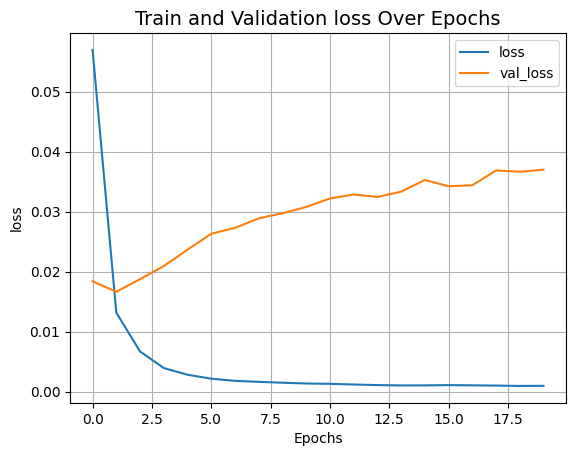

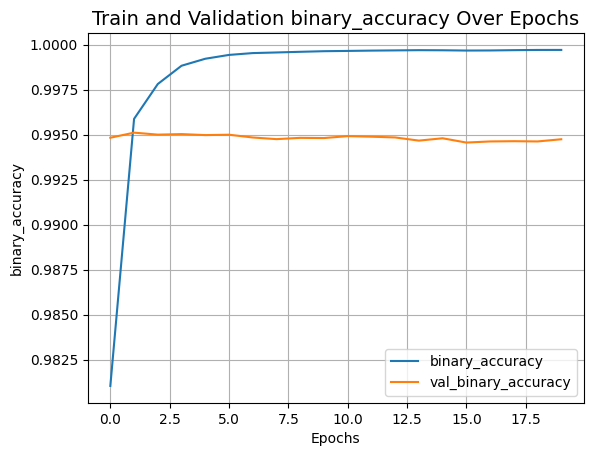

In [29]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [30]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

11/11 [==============================] - 0s 11ms/step - loss: 0.0400 - binary_accuracy: 0.9946
Categorical accuracy on the test set: 99.46%.


In [31]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_5_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    print(f"Predicted Label(s): ({', '.join([label for label in top_5_labels])})")
    print(" ")

4/4 [==============================] - 0s 6ms/step
Text: b'beli theme wordpress company profile halo saya lagi cari yang jual theme wordpress company profile siap pakai siapa tahu sini ada yang punya utama yang responsif dan tidak null ya'
Label(s): ['Wordpress Templates']
Predicted Label(s): (Wordpress Templates, Wordpress, Copywriter, Website, Blog)
 
Text: b'beri review google map bikin 60 email baru dan beri review di map google lama 1 2 bulan untuk tingkat rating tinggal no hp wa agar bisa di hubung thx'
Label(s): ['Data Entry' 'Administration']
Predicted Label(s): (Internet Marketing, Writing, Search Engine Optimization (SEO), Reviews, Blogspot)
 
Text: b'butuh desain kaos clothing men atau women wear kami online clothing yang sudah jalan lama 3 tahun kami jual beberapa produk dari pakai pria maupun wanita saat ini kami butuh desainer yang dapat buat beberapa desain untuk clothingan kami belum kami desain sendiri kaos kaos sebut jika memang cocok dengan desain kita dapat kerja sa